In [1]:
import numpy as np
from astropy.io import fits
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import os
from scipy import interpolate

from rascal.calibrator import Calibrator
from rascal import models
from rascal import util

import sys

/Users/marcolam/git/rascal/rascal/calibrator.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
sys.path.append('../../bhtomspec/GMOS')

from gmos_fieldflattening import create_pixel_array

pixels = create_pixel_array('north', 2)
rawpix_to_pix_itp = interpolate.interp1d(np.arange(len(pixels)), pixels)

In [3]:
# Load the data
base_dir = os.path.dirname('.')
spectrum2D = fits.open(
    os.path.join(base_dir,
                 'data_gemini_gmos/N20181115S0215_flattened.fits'))[0].data

# Collapse into 1D spectrum between row 110 and 120
spectrum = np.median(spectrum2D[300:310], axis=0)[::-1]

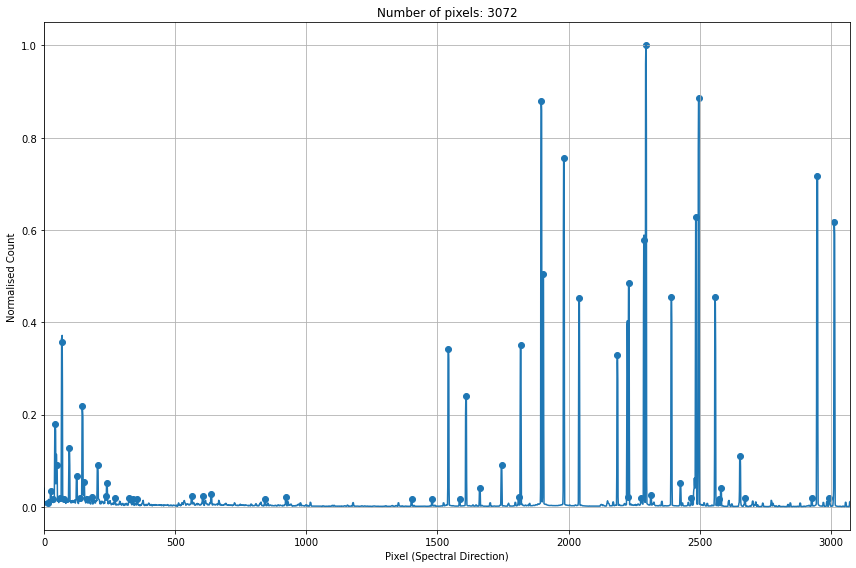

In [4]:
# Identify the peaks
peaks, _ = find_peaks(spectrum, height=1000, distance=5, threshold=None)
peaks = util.refine_peaks(spectrum, peaks, window_width=5)

peaks_shifted = rawpix_to_pix_itp(peaks)

plt.figure(1, figsize=(12, 8))
plt.clf()
plt.plot(pixels, spectrum / spectrum.max())
plt.scatter(peaks_shifted, spectrum[peaks.astype('int')] / spectrum.max())
plt.title('Number of pixels: ' + str(spectrum.shape[0]))
plt.xlabel("Pixel (Spectral Direction)")
plt.ylabel("Normalised Count")
plt.xlim(0, 3072)
plt.grid()
plt.tight_layout()

INFO:rascal.calibrator:num_pix is set to None.
INFO:rascal.calibrator:pixel_list is set to None.
INFO:rascal.calibrator:Plotting with matplotlib.
INFO:rascal.calibrator:num_pix is set to None.
INFO:rascal.calibrator:pixel_list is set to [0.000e+00 1.000e+00 2.000e+00 ... 3.136e+03 3.137e+03 3.138e+03].
INFO:rascal.calibrator:Plotting with matplotlib.


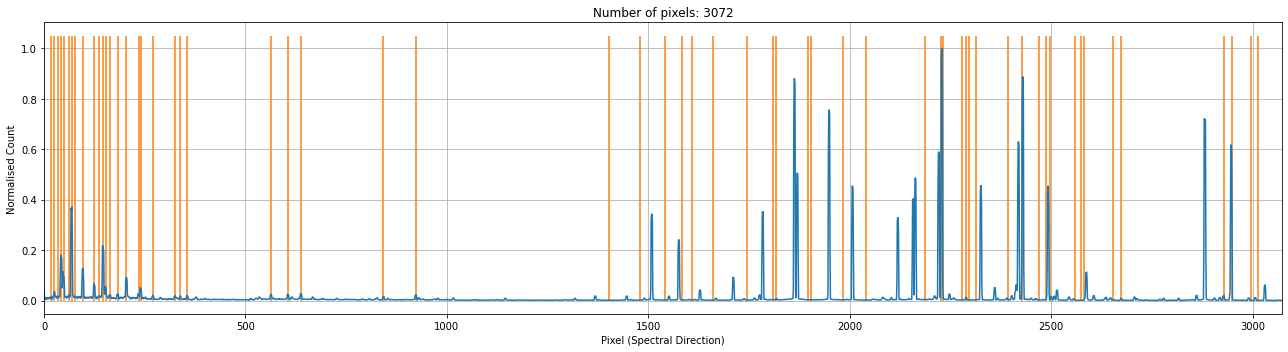

In [5]:
# Initialise the calibrator
c = Calibrator(peaks_shifted, spectrum=spectrum)
c.set_calibrator_properties(pixel_list=pixels)
c.plot_arc()
c.set_hough_properties(num_slopes=5000,
                       range_tolerance=500.,
                       xbins=200,
                       ybins=200,
                       min_wavelength=5000.,
                       max_wavelength=9500.)
c.set_ransac_properties(sample_size=5,
                        top_n_candidate=5)
# Vacuum wavelengths
# blend: 5143.21509, 5146.74143
# something weird near there, so not used: 8008.359, 8016.990
atlas = [
    4703.632, 4728.19041, 4766.19677, 4807.36348, 4849.16386, 4881.22627,
    4890.40721, 4906.12088, 4934.58593, 4966.46490, 5018.56194, 5063.44827,
    5163.723, 5189.191, 5497.401, 5560.246, 5608.290, 5913.723, 6754.698,
    6873.185, 6967.352, 7032.190, 7069.167, 7149.012, 7274.940, 7386.014,
    7505.935, 7516.721, 7637.208, 7725.887, 7893.246, 7950.362, 8105.921,
    8117.542, 8266.794, 8410.521, 8426.963, 8523.783, 8670.325, 9125.471,
    9197.161, 9227.03, 9356.787, 9660.435, 9787.186
]

element = ['CuAr'] * len(atlas)

c.load_user_atlas(elements=element,
                  wavelengths=atlas,
                  vacuum=True,
                  pressure=61700.,
                  temperature=276.55,
                  relative_humidity=4.)
c.do_hough_transform()

INFO:rascal.calibrator:Peak at: 4690.432939431677 A
INFO:rascal.calibrator:Peak at: 4703.69698080062 A
INFO:rascal.calibrator:- matched to 4703.6319466224995 A
INFO:rascal.calibrator:Peak at: 4716.026520809748 A
INFO:rascal.calibrator:Peak at: 4728.383743644213 A
INFO:rascal.calibrator:- matched to 4728.190356343808 A


INFO:rascal.calibrator:Peak at: 4737.097090466034 A
INFO:rascal.calibrator:Peak at: 4757.491217560396 A
INFO:rascal.calibrator:Peak at: 4766.093311886265 A
INFO:rascal.calibrator:- matched to 4766.196715912505 A
INFO:rascal.calibrator:Peak at: 4780.210922721128 A
INFO:rascal.calibrator:Peak at: 4807.206845286494 A
INFO:rascal.calibrator:- matched to 4807.36342544534 A
INFO:rascal.calibrator:Peak at: 4848.935535742634 A
INFO:rascal.calibrator:- matched to 4849.163804970983 A
INFO:rascal.calibrator:Peak at: 4866.990349869678 A
INFO:rascal.calibrator:Peak at: 4881.167498144336 A
INFO:rascal.calibrator:- matched to 4881.226214607134 A
INFO:rascal.calibrator:Peak at: 4890.591318605304 A
INFO:rascal.calibrator:- matched to 4890.407154502948 A
INFO:rascal.calibrator:Peak at: 4905.728124841728 A
INFO:rascal.calibrator:- matched to 4906.120824324627 A
INFO:rascal.calibrator:Peak at: 4934.778999493386 A
INFO:rascal.calibrator:- matched to 4934.585874001602 A
INFO:rascal.calibrator:Peak at: 4966.

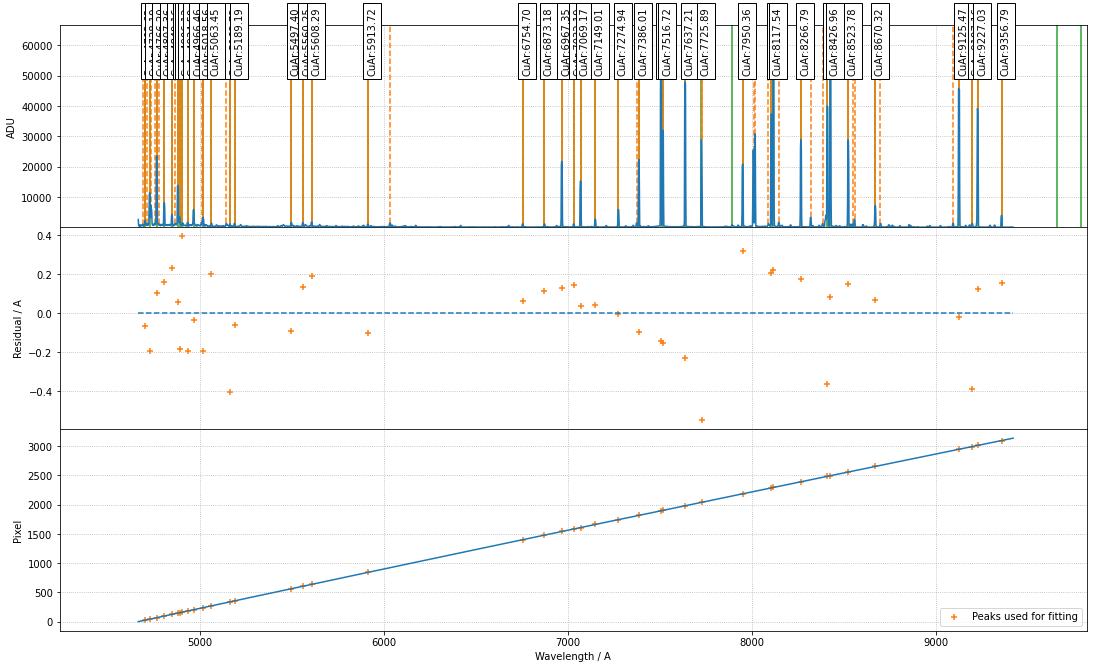

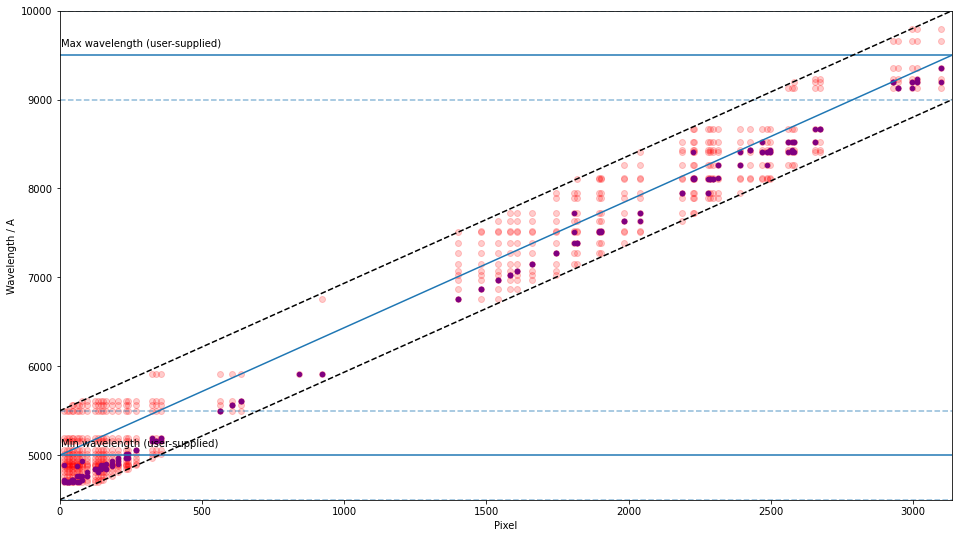

RMS: 0.20199868705514198
Stdev error: 0.20199868705514198 A
Peaks utilisation rate: 93.33333333333333%


In [6]:
# Run the wavelength calibration
fit_coeff, rms, residual, peak_utilisation = c.fit(max_tries=1000, fit_deg=4)

# Plot the solution
c.plot_fit(fit_coeff, spectrum, plot_atlas=True, log_spectrum=False, tolerance=5.)

# Show the parameter space for searching possible solution
c.plot_search_space()

print("RMS: {}".format(rms))
print("Stdev error: {} A".format(residual.std()))
print("Peaks utilisation rate: {}%".format(peak_utilisation * 100))
